In [44]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import matplotlib.pyplot as plt

In [24]:
data = {
    'tra':
    pd.read_csv('air_visit_data.csv'),
    'as':
    pd.read_csv('air_store_info.csv'),
    'hs':
    pd.read_csv('hpg_store_info.csv'),
    'ar':
    pd.read_csv('air_reserve.csv'),
    'hr':
    pd.read_csv('hpg_reserve.csv'),
    'id':
    pd.read_csv('store_id_relation.csv'),
    'tes':
    pd.read_csv('sample_submission.csv'),
    'hol':
    pd.read_csv('date_info.csv').rename(columns={'calendar_date': 'visit_date'})
}

In [25]:
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])

In [26]:
for df in ['ar', 'hr']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    data[df]['reserve_datetime_diff'] = data[df].apply(
        lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    data[df] = data[df].groupby(
        ['air_store_id', 'visit_datetime'], as_index=False)[[
            'reserve_datetime_diff', 'reserve_visitors'
        ]].sum().rename(columns={
            'visit_datetime': 'visit_date'
        })
    print(data[df].head())

           air_store_id  visit_date  reserve_datetime_diff  reserve_visitors
0  air_00a91d42b08b08d9  2016-10-31                      0                 2
1  air_00a91d42b08b08d9  2016-12-05                      4                 9
2  air_00a91d42b08b08d9  2016-12-14                      6                18
3  air_00a91d42b08b08d9  2016-12-17                      6                 2
4  air_00a91d42b08b08d9  2016-12-20                      2                 4
           air_store_id  visit_date  reserve_datetime_diff  reserve_visitors
0  air_00a91d42b08b08d9  2016-01-14                      3                 2
1  air_00a91d42b08b08d9  2016-01-15                      6                 4
2  air_00a91d42b08b08d9  2016-01-16                      3                 2
3  air_00a91d42b08b08d9  2016-01-22                      3                 2
4  air_00a91d42b08b08d9  2016-01-29                      6                 5


In [27]:
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date

In [28]:
data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date

In [29]:
unique_stores = data['tes']['air_store_id'].unique()
stores = pd.concat(
    [
        pd.DataFrame({
            'air_store_id': unique_stores,
            'dow': [i] * len(unique_stores)
        }) for i in range(7)
    ],
    axis=0,
    ignore_index=True).reset_index(drop=True)

In [30]:
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].min().rename(columns={
        'visitors': 'min_visitors'
    })

In [31]:
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

In [32]:
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].mean().rename(columns={
        'visitors': 'mean_visitors'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].median().rename(columns={
        'visitors': 'median_visitors'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].max().rename(columns={
        'visitors': 'max_visitors'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].count().rename(columns={
        'visitors': 'count_observations'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

In [33]:
stores = pd.merge(stores, data['as'], how='left', on=['air_store_id'])
lbl = preprocessing.LabelEncoder()
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

In [34]:
data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date

In [35]:
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date'])
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date'])

train = pd.merge(data['tra'], stores, how='left', on=['air_store_id', 'dow'])
test = pd.merge(data['tes'], stores, how='left', on=['air_store_id', 'dow'])

In [36]:
for df in ['ar', 'hr']:
    train = pd.merge(
        train, data[df], how='left', on=['air_store_id', 'visit_date'])
    test = pd.merge(
        test, data[df], how='left', on=['air_store_id', 'visit_date'])

col = [
    c for c in train
    if c not in ['id', 'air_store_id', 'visit_date', 'visitors']
]
train = train.fillna(-1)
test = test.fillna(-1)

In [37]:
print('Binding to float32')

Binding to float32


In [38]:
for c, dtype in zip(train.columns, train.dtypes):
    if dtype == np.float64:
        train[c] = train[c].astype(np.float32)

In [39]:
for c, dtype in zip(test.columns, test.dtypes):
    if dtype == np.float64:
        test[c] = test[c].astype(np.float32)

In [40]:
train_x = train.drop(['air_store_id', 'visit_date', 'visitors'], axis=1)
train_y = np.log1p(train['visitors'].values)
print(train_x.shape, train_y.shape)
test_x = test.drop(['id', 'air_store_id', 'visit_date', 'visitors'], axis=1)

(252108, 16) (252108,)


In [41]:
boost_params = {'eval_metric': 'rmse'}
xgb0 = xgb.XGBRegressor(
    max_depth=8,
    learning_rate=0.01,
    n_estimators=10000,
    objective='reg:linear',
    gamma=0,
    min_child_weight=1,
    subsample=1,
    colsample_bytree=1,
    scale_pos_weight=1,
    seed=27,
    **boost_params)

In [42]:
xgb0.fit(train_x, train_y)
predict_y = xgb0.predict(test_x)
test['visitors'] = np.expm1(predict_y)
test[['id', 'visitors']].to_csv(
    'xgb0_submission.csv', index=False, float_format='%.3f')

[22:48:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [43]:
print(test)

                                    id   visitors  visit_date  \
0      air_00a91d42b08b08d9_2017-04-23   2.152977  2017-04-23   
1      air_00a91d42b08b08d9_2017-04-24  21.426897  2017-04-24   
2      air_00a91d42b08b08d9_2017-04-25  22.978199  2017-04-25   
3      air_00a91d42b08b08d9_2017-04-26  28.513926  2017-04-26   
4      air_00a91d42b08b08d9_2017-04-27  30.379351  2017-04-27   
...                                ...        ...         ...   
32014  air_fff68b929994bfbd_2017-05-27   6.830283  2017-05-27   
32015  air_fff68b929994bfbd_2017-05-28   3.532686  2017-05-28   
32016  air_fff68b929994bfbd_2017-05-29   3.375839  2017-05-29   
32017  air_fff68b929994bfbd_2017-05-30   3.794607  2017-05-30   
32018  air_fff68b929994bfbd_2017-05-31   3.873036  2017-05-31   

               air_store_id  dow  year  month  min_visitors  mean_visitors  \
0      air_00a91d42b08b08d9    6  2017      4           2.0       2.000000   
1      air_00a91d42b08b08d9    0  2017      4           1.0    

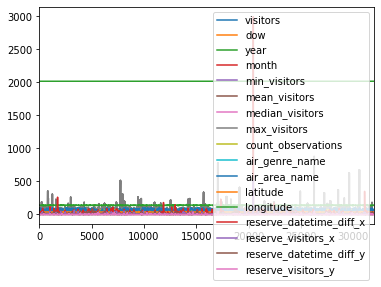

In [47]:
test.plot()